# Chapter 2

Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [3]:
import numpy as np

In [4]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

Given a list of values, there are several ways to count the frequency of each value.

In [5]:
t = [1, 2, 2, 3, 5]

You can use a Python dictionary:

In [6]:
hist = {}
for x in t:
    hist[x] = hist.get(x, 0) + 1
    
hist

{1: 1, 2: 2, 3: 1, 5: 1}

You can use a `Counter` (which is a dictionary with additional methods):

In [7]:
from collections import Counter
counter = Counter(t)
counter

Counter({1: 1, 2: 2, 3: 1, 5: 1})

Or you can use the `Hist` object provided by `thinkstats2`:

In [8]:
import thinkstats2
hist = thinkstats2.Hist([1, 2, 2, 3, 5])
hist

Hist({1: 1, 2: 2, 3: 1, 5: 1})

`Hist` provides `Freq`, which looks up the frequency of a value.

In [9]:
hist.Freq(2)

2

You can also use the bracket operator, which does the same thing.

In [10]:
hist[2]

2

If the value does not appear, it has frequency 0.

In [11]:
hist[4]

0

The `Values` method returns the values:

In [12]:
hist.Values()

dict_keys([1, 2, 3, 5])

So you can iterate the values and their frequencies like this:

In [13]:
for val in sorted(hist.Values()):
    print(val, hist[val])

1 1
2 2
3 1
5 1


Or you can use the `Items` method:

In [14]:
for val, freq in hist.Items():
     print(val, freq)

1 1
2 2
3 1
5 1


`thinkplot` is a wrapper for `matplotlib` that provides functions that work with the objects in `thinkstats2`.

For example `Hist` plots the values and their frequencies as a bar graph.

`Config` takes parameters that label the x and y axes, among other things.

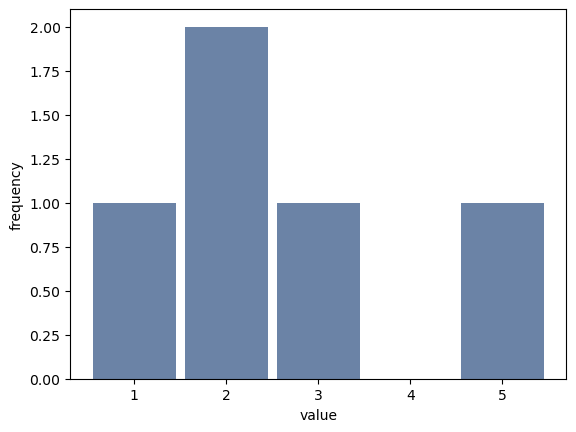

In [15]:
import thinkplot
thinkplot.Hist(hist)
thinkplot.Config(xlabel='value', ylabel='frequency')

As an example, I'll replicate some of the figures from the book.

First, I'll load the data from the pregnancy file and select the records for live births.

In [16]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")

download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

In [17]:
import nsfg

In [18]:
preg = nsfg.ReadFemPreg()
live = preg[preg.outcome == 1]

Here's the histogram of birth weights in pounds.  Notice that `Hist` works with anything iterable, including a Pandas Series.  The `label` attribute appears in the legend when you plot the `Hist`. 

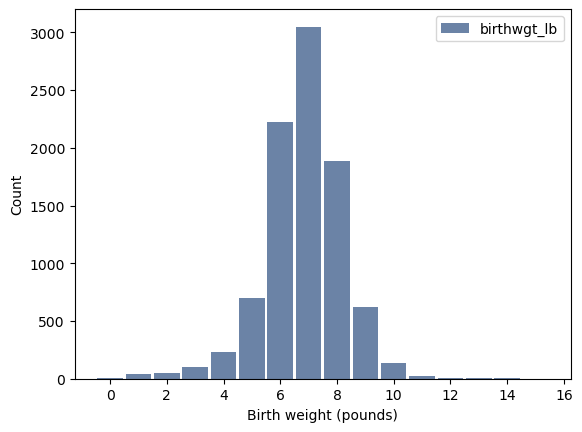

In [19]:
hist = thinkstats2.Hist(live.birthwgt_lb, label='birthwgt_lb')
thinkplot.Hist(hist)
thinkplot.Config(xlabel='Birth weight (pounds)', ylabel='Count')

Before plotting the ages, I'll apply `floor` to round down:

In [20]:
ages = np.floor(live.agepreg)

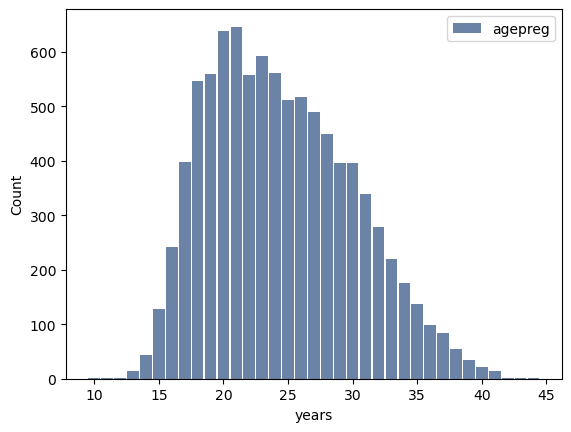

In [21]:
hist = thinkstats2.Hist(ages, label='agepreg')
thinkplot.Hist(hist)
thinkplot.Config(xlabel='years', ylabel='Count')

As an exercise, plot the histogram of pregnancy lengths (column `prglngth`).

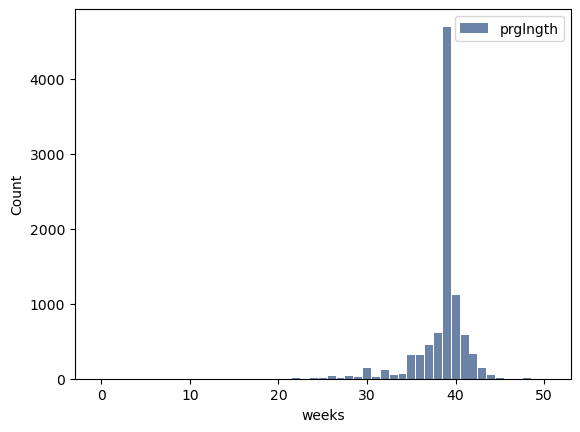

In [22]:
preg_length = np.floor(live.prglngth)
hist = thinkstats2.Hist(preg_length, label='prglngth')
thinkplot.Hist(hist)
thinkplot.config(xlabel='weeks', ylabel='Count')

`Hist` provides smallest, which select the lowest values and their frequencies.

In [23]:
for weeks, freq in hist.Smallest(10):
    print(weeks, freq)

0.0 1
4.0 1
9.0 1
13.0 1
17.0 2
18.0 1
19.0 1
20.0 1
21.0 2
22.0 7


Use `Largest` to display the longest pregnancy lengths.

In [24]:
for weeks, frequency in hist.Largest(10):
    print(weeks, frequency)


50.0 2
48.0 7
47.0 1
46.0 1
45.0 10
44.0 46
43.0 148
42.0 328
41.0 587
40.0 1116


From live births, we can select first babies and others using `birthord`, then compute histograms of pregnancy length for the two groups.

In [25]:
firsts = live[live.birthord == 1]
others = live[live.birthord != 1]

first_hist = thinkstats2.Hist(firsts.prglngth, label='first')
other_hist = thinkstats2.Hist(others.prglngth, label='other')

We can use `width` and `align` to plot two histograms side-by-side.

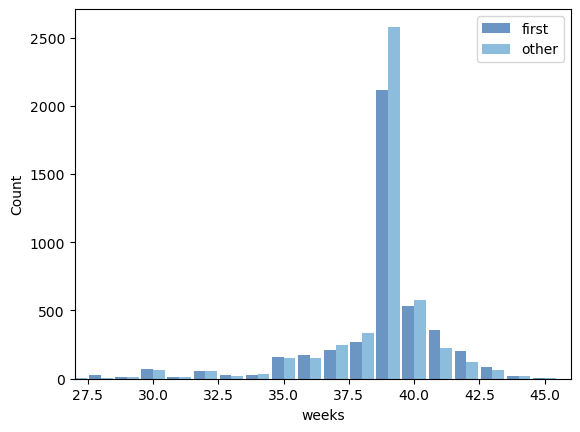

In [26]:
width = 0.45
thinkplot.PrePlot(2)
thinkplot.Hist(first_hist, align='right', width=width)
thinkplot.Hist(other_hist, align='left', width=width)
thinkplot.Config(xlabel='weeks', ylabel='Count', xlim=[27, 46])

`Series` provides methods to compute summary statistics:

In [27]:
mean = live.prglngth.mean()
var = live.prglngth.var()
std = live.prglngth.std()

Here are the mean and standard deviation:

In [28]:
mean, std

(38.56055968517709, 2.702343810070593)

As an exercise, confirm that `std` is the square root of `var`:

In [35]:
np.sqrt(var)==std

True

Here's are the mean pregnancy lengths for first babies and others:

In [30]:
firsts.prglngth.mean(), others.prglngth.mean()

(38.60095173351461, 38.52291446673706)

And here's the difference (in weeks):

In [31]:
firsts.prglngth.mean() - others.prglngth.mean()

0.07803726677754952

This functon computes the Cohen effect size, which is the difference in means expressed in number of standard deviations:

In [32]:
def CohenEffectSize(group1, group2):
    """Computes Cohen's effect size for two groups.
    
    group1: Series or DataFrame
    group2: Series or DataFrame
    
    returns: float if the arguments are Series;
             Series if the arguments are DataFrames
    """
    diff = group1.mean() - group2.mean()

    var1 = group1.var()
    var2 = group2.var()
    n1, n2 = len(group1), len(group2)

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / np.sqrt(pooled_var)
    return d

Compute the Cohen effect size for the difference in pregnancy length for first babies and others.

In [39]:
CohenEffectSize(firsts.prglngth, others.prglngth)

0.028879044654449883

## Exercises

Using the variable `totalwgt_lb`, investigate whether first babies are lighter or heavier than others. 

Compute Cohen’s effect size to quantify the difference between the groups.  How does it compare to the difference in pregnancy length?

In [43]:
first_weight_mean = firsts.totalwgt_lb.mean()
others_weight_mean = others.totalwgt_lb.mean()
if first_weight_mean > others_weight_mean:
    print(f"First babies with a mean of {first_weight_mean} are not lighter than \
other babies with a mean of {others_weight_mean}")
else:
    print(f"First babies with a mean of {first_weight_mean} are lighter than other \
babies with a mean of {others_weight_mean}")

First babies with a mean of 7.201094430437772 are lighter than other babies with a mean of 7.325855614973262


In [44]:
CohenEffectSize(firsts.totalwgt_lb, others.totalwgt_lb)

-0.088672927072602

For the next few exercises, we'll load the respondent file:

In [33]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dat.gz")

In [34]:
resp = nsfg.ReadFemResp()

Make a histogram of <tt>totincr</tt> the total income for the respondent's family.  To interpret the codes see the [codebook](ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Dataset_Documentation/NSFG/Cycle6Codebook-Pregnancy.pdf).

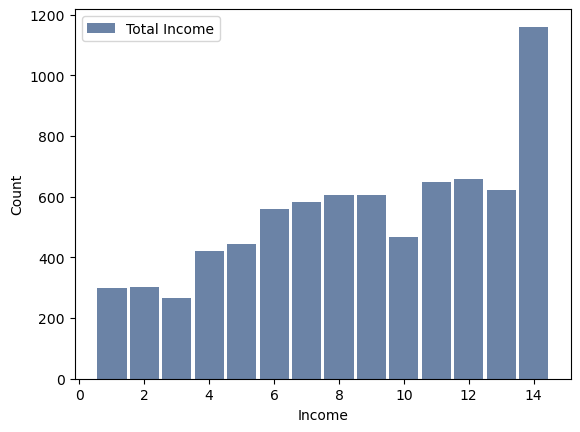

In [47]:
hist = thinkstats2.Hist(resp.totincr, label='Total Income')
thinkplot.Hist(hist)
thinkplot.Config(xlabel='Income', ylabel='Count')

Make a histogram of <tt>age_r</tt>, the respondent's age at the time of interview.

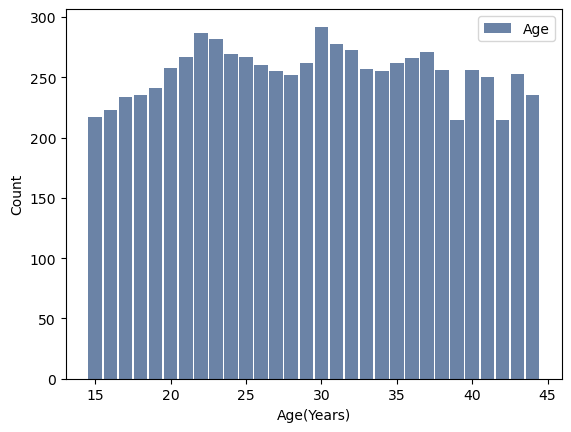

In [52]:
hist = thinkstats2.Hist(resp.age_r, label='Age')
thinkplot.Hist(hist)
thinkplot.Config(xlabel='Age(Years)', ylabel='Count')

Make a histogram of <tt>numfmhh</tt>, the number of people in the respondent's household.

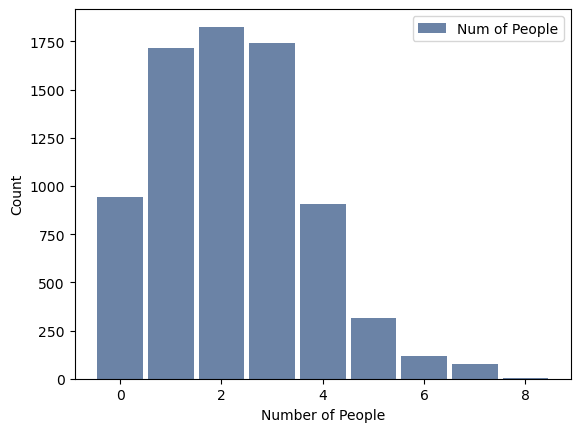

In [53]:
hist = thinkstats2.Hist(resp.numfmhh, label='Num of People')
thinkplot.Hist(hist)
thinkplot.Config(xlabel='Number of People', ylabel='Count')

Make a histogram of <tt>parity</tt>, the number of children borne by the respondent.  How would you describe this distribution?

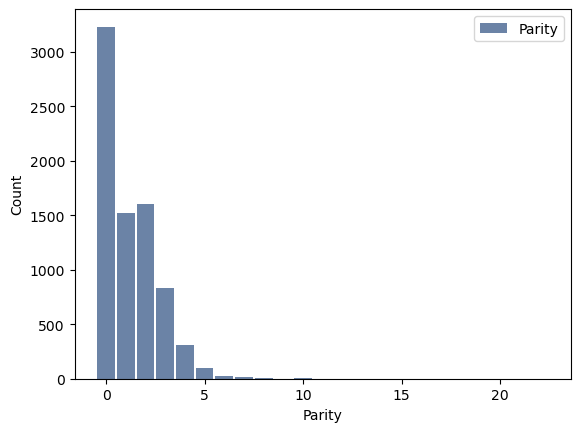

In [54]:
hist = thinkstats2.Hist(resp.parity, label='Parity')
thinkplot.Hist(hist)
thinkplot.Config(xlabel='Parity', ylabel='Count')

Use Hist.Largest to find the largest values of <tt>parity</tt>.

In [60]:
hist = thinkstats2.Hist(hist)

for parity, freq in hist.Largest():
    print(parity, freq)

22 1
16 1
10 3
9 2
8 8
7 15
6 29
5 95
4 309
3 828


Let's investigate whether people with higher income have higher parity.  Keep in mind that in this study, we are observing different people at different times during their lives, so this data is not the best choice for answering this question.  But for now let's take it at face value.

Use <tt>totincr</tt> to select the respondents with the highest income (level 14).  Plot the histogram of <tt>parity</tt> for just the high income respondents.

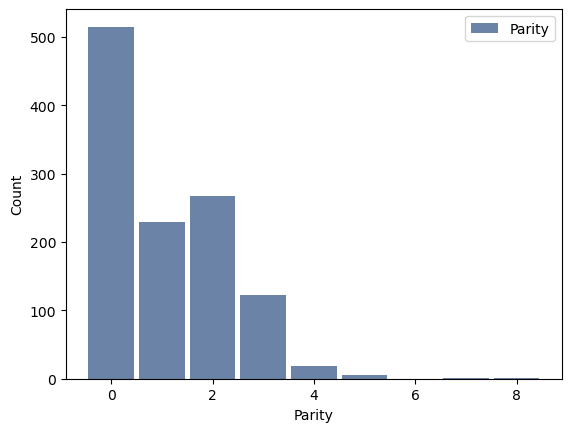

In [70]:
rich = resp[resp.totincr==14]
hist = thinkstats2.Hist(rich.parity)
thinkplot.Hist(hist, label='Parity')
thinkplot.Config(xlabel='Parity', ylabel='Count')

Find the largest parities for high income respondents.

In [72]:
hist.Largest(10)

[(8, 1), (7, 1), (5, 5), (4, 19), (3, 123), (2, 267), (1, 229), (0, 515)]

Compare the mean <tt>parity</tt> for high income respondents and others.

In [76]:
others = resp[resp.totincr!=14]
print(rich.parity.mean(), others.parity.mean())

1.0758620689655172 1.2495758136665125


Compute the Cohen effect size for this difference.  How does it compare with the difference in pregnancy length for first babies and others?

-0.1251185531466061

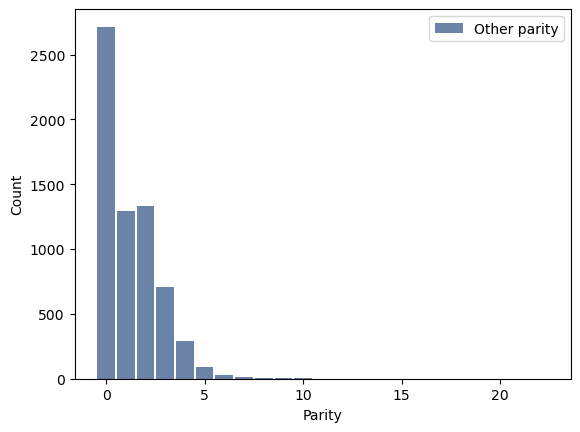

In [77]:
others = resp[resp.totincr!=14]
hist = thinkstats2.Hist(others.parity)
thinkplot.Hist(hist, label='Other parity')
thinkplot.Config(xlabel='Parity', ylabel='Count')

CohenEffectSize(rich.parity, others.parity)